# Keras Functional API

## Classify images with a toy ResNet

In this notebook, we will train a reduced version of the popular ResNet neural network, which uses residual connections, to classify images from the CIFAR10 dataset. The notebook is based on the public tutorial found here: https://www.tensorflow.org/guide/keras/functional

##### Import the required modules

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

2021-12-22 12:54:47.746950: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-22 12:54:47.746975: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


##### Download the CIFAR10 Dataset

As in the previous notebook, will use the `keras.datasets` package to download the dataset. We will also do some (manual) normalization of the data. Notice that it's actually better to use a `Normalization()` Keras layer, so that the input pipeline remains part of your model (more portable). But this will do for a simple example.

The `to_categorical` method applies one-hot encoding to the integer class labels. 

In [2]:
(x_train, y_train_int), (x_test, y_test_int) = keras.datasets.cifar10.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = keras.utils.to_categorical(y_train_int, 10)
y_test = keras.utils.to_categorical(y_test_int, 10)


CIFAR10 contains 32x32 color images, so the shape of `x_train` and `x_test` is $(n_{images}, 32, 32, 3)$, whereas the shape of `y_train` and `y_test` is $(n_{images}, 10)$ because of the one-hot encoding.

In [3]:
print(x_train.shape)
print(y_train.shape)

(50000, 32, 32, 3)
(50000, 10)


Let us define the class names (they are not defined in the dataset)

In [4]:
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

Finally, let us plot some images as an example. Wow, the resolution is quite low...!

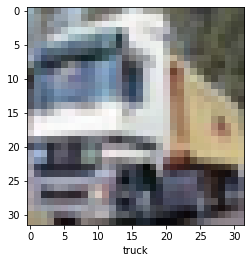

In [5]:
idx = 1
plt.figure()
plt.imshow(x_train[idx])
plt.xlabel(class_names[y_train_int[idx][0]])
plt.grid(False)
plt.show()

##### Let us build a small ResNet-like CNN model with the Functional API

In doing this, we are also seing some new important layers, such as `Input`, `Conv2D`, `MaxPooling2D`, `Dropout`, `add` (element-wise addition), etc. 

- The `Conv2D` layer takes as mandatory parameters the number of output channels and the kernel size. Optional parameters include the stride, the activation function, the padding type, etc.
- The `MaxPooling2D` layer takes as mandatory parameter the pool size. Optional parameters include the stride (defaults to `pool_size`, the padding type, etc.
- The `Dropout` layer takes as mandatory parameter the dropout rate.
- The `add` layer does not have parameters.


Notice that since the `add` layers take two inputs from different parts of the network, this model could not be defined using the Sequential API.

Notice the final `keras.Model` call which specifies the inputs and outputs of our model's graph.

In [6]:
inputs = keras.Input(shape=(32, 32, 3), name="img")
x = keras.layers.Conv2D(32, 3, activation="relu")(inputs)
x = keras.layers.Conv2D(64, 3, activation="relu")(x)
block_1_output = keras.layers.MaxPooling2D(3)(x)

x = keras.layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
x = keras.layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_2_output = keras.layers.add([x, block_1_output])

x = keras.layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
x = keras.layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_3_output = keras.layers.add([x, block_2_output])

x = keras.layers.Conv2D(64, 3, activation="relu")(block_3_output)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(10)(x)

model = keras.Model(inputs, outputs, name="toy_resnet")

2021-12-22 12:54:51.541150: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-22 12:54:51.541182: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-22 12:54:51.541203: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (matteo-Inspiron-7591-2n1): /proc/driver/nvidia/version does not exist
2021-12-22 12:54:51.541396: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Let us show a summary of the model and plot it.

In [7]:
model.summary()

Model: "toy_resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 30, 30, 32)   896         ['img[0][0]']                    
                                                                                                  
 conv2d_1 (Conv2D)              (None, 28, 28, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 9, 9, 64)     0           ['conv2d_1[0][0]']               
                                                                                         

In [8]:
keras.utils.plot_model(model, 'toy_resnet.png', show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


##### Compile the model

Let us now compile the model, specifying optimizer, loss function and metrics.

Notice that, differently from the previous notebook, we use `RMSprop` instead of `Adam` this time. We also use the `CategoricalCrossentropy` loss (not the "sparse" variant) since we have generated 1-hot labels, and we use the `from_logits` option because the last layer of the model does not include a softmax activation. This approach is normally more stable from a numerical point of view, so it's suggested.


In [9]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

##### Train the model

Notice the new option `validation_split=0.2`. More details on this later.

In [ ]:
model.fit(x_train, y_train, batch_size=64, epochs=10, validation_split=0.2)

2021-12-22 12:54:52.323671: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 491520000 exceeds 10% of free system memory.


Epoch 1/10
  3/625 [..............................] - ETA: 45s - loss: 2.3347 - accuracy: 0.1094

2021-12-22 12:54:53.756036: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 24385536 exceeds 10% of free system memory.
2021-12-22 12:54:53.756132: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 24385536 exceeds 10% of free system memory.
2021-12-22 12:54:53.830640: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 24385536 exceeds 10% of free system memory.
2021-12-22 12:54:53.830870: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 24385536 exceeds 10% of free system memory.


625/625 [==============================] - 63s 100ms/step - loss: 1.8937 - accuracy: 0.2747 - val_loss: 1.6652 - val_accuracy: 0.3840
Epoch 2/10
625/625 [==============================] - 72s 115ms/step - loss: 1.4862 - accuracy: 0.4557 - val_loss: 1.3847 - val_accuracy: 0.4975
Epoch 3/10
625/625 [==============================] - 67s 108ms/step - loss: 1.2711 - accuracy: 0.5434 - val_loss: 1.0475 - val_accuracy: 0.6205
Epoch 4/10
625/625 [==============================] - 72s 115ms/step - loss: 1.0941 - accuracy: 0.6122 - val_loss: 0.9841 - val_accuracy: 0.6404
Epoch 5/10
625/625 [==============================] - 70s 112ms/step - loss: 0.9675 - accuracy: 0.6604 - val_loss: 0.9402 - val_accuracy: 0.6658
Epoch 6/10
625/625 [==============================] - 79s 126ms/step - loss: 0.8790 - accuracy: 0.6943 - val_loss: 0.8067 - val_accuracy: 0.7175
Epoch 7/10
625/625 [==============================] - 66s 106ms/step - loss: 0.8018 - accuracy: 0.7243 - val_loss: 0.7851 - val_accuracy: 0.7

##### Evaluate on unseen data

Let us test the model on unseen data using the `evaluate()` method. The model is slightly over-fitting the training data.

In [ ]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
print('\nTest accuracy:', test_acc)

##### Perform a prediction on a single image

Let us run a prediction on one image and see the result. Notice that the bar chart is negative this time because we have logits, not probabilities.

In [ ]:
idx = 1

pred = model.predict(x_test[idx].reshape(1, 32, 32, 3))
pred_lidx = tf.argmax(pred[0])
pred_label = class_names[pred_lidx]

print("Predicted label: {} ({})".format(pred_lidx, pred_label))
print("Real label: {} ({})".format(y_test_int[idx][0], class_names[y_test_int[idx][0]]))

plt.figure()
plt.imshow(x_test[idx])
plt.grid(False)
plt.figure()
plt.bar(range(len(class_names)), pred[0], tick_label=class_names)
plt.xticks(rotation=45)
plt.show()